Importing packages. Install GetOldTweets3 in order to scrape twitter, pip install GetOldTweets3.

In [2]:
#from twitter_scraper import get_tweets
#pip install GetOldTweets3

import time
import timeit
import GetOldTweets3 as got
import pandas as pd
from afinn import Afinn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

Defining the scraping function to extract tweets from Twitter by utilizing the package GetOldTweets3

In [3]:
# Function that pulls tweets based on a general search query and turns to csv file

# Parameters: (text query you want to search), (max number of most recent tweets to pull from)
def twitter_scrape(keys):
    
    #Empty list to append the looped extract of tweets
    text_tweets = []
    
    # Creation of query object with restrictions for language: Danish, period: 2019-06-05 to 2020-09-01
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(keys).setLang('da')\
                            .setSince('2019-06-05').setUntil('2020-08-26')
    
    # Creation of list that contains all tweets
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    
    #Incorporating a delay so that the scrape does not exceed Twitters limit of 18,000 tweets every 15 minutes
    #This delay is 0.06 seconds per tweet due to (15*60)/18,000=0.05, 0.06 to be on the safe side
    for tweet in tweets:
        data = [tweet.date, tweet.text, tweet.id]
        text_tweets.append(data)
        time.sleep(0.06)
    
    # Creation of dataframe from tweets
    tweets_df = pd.DataFrame(text_tweets, columns = ['date', 'text', 'id'])
    
    #Adding a column in order to separate the data by the keyword
    tweets_df['key'] = f'{keys}'
    
    # Converting tweets dataframe to csv file
    tweets_df.to_csv(f'{keys}.csv', sep=';', encoding='utf-8-sig')

Calling the function on a list of the keywords

In [4]:
#The scrape does not differentiate between lower and upper case letters
#I have serparated the entire scrape in two, because it had difficulties running them all in one go
keys = ['Mette Frederiksen', 'Mette F', 'Søren Brostrøm', '@SSTbrostrom',\
        'Magnus Heunicke', 'Heunicke', 'Kåre Mølbak', '@karemolbak', 'Covid Danmark']

key_1 = ['Mette Frederiksen', 'Mette F', 'Søren Brostrøm', '@SSTbrostrom', 'Magnus Heunicke']
key_2 = ['Heunicke', 'Kåre Mølbak', '@karemolbak', 'Covid Danmark']


[twitter_scrape(key) for key in key_1]

time.sleep(900)

[twitter_scrape(key) for key in key_2]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



An error occured during an HTTP request: HTTP Error 429: Too Many Requests
Try to open in browser: https://twitter.com/search?q=Heunicke%20since%3A2019-06-05%20until%3A2020-08-26&src=typd
Traceback (most recent call last):
  File "C:\Users\Jeanette\Anaconda\lib\site-packages\GetOldTweets3\manager\TweetManager.py", line 343, in getJsonResponse
    response = opener.open(url)
  File "C:\Users\Jeanette\Anaconda\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "C:\Users\Jeanette\Anaconda\lib\urllib\request.py", line 640, in http_response
    response = self.parent.error(
  File "C:\Users\Jeanette\Anaconda\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "C:\Users\Jeanette\Anaconda\lib\urllib\request.py", line 502, in _call_chain
    result = func(*args)
  File "C:\Users\Jeanette\Anaconda\lib\urllib\request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError:

TypeError: object of type 'NoneType' has no len()

Data cleansing

In [6]:
#keys = ['Mette Frederiksen', 'Mette F', 'Søren Brostrøm', '@SSTbrostrom', 'Magnus Heunicke', 'Heunicke']

#Reading the csv files and creating dataframes
twitter_lists = [pd.read_csv(f'{key}.csv', sep=';') for key in keys]

#Concatenation of the dataframes for each person
twitter_lists = pd.concat(twitter_lists).sort_values('date')

#Cleaning the date to only state the date of the day by removing the last part of the string, the time of the day
twitter_lists['date'] = twitter_lists['date'].str[0:10]

#For some reason the scrape have extracted tweets from dates beyond the period set in GetOldTweets3
#These are removed by the next two lines of code
period = (twitter_lists['date'] >= '2019-06-05') & (twitter_lists['date'] <= '2020-08-26')

#Removes tweets from before the period specified in the "twitter_scrape" function
twitter_lists = twitter_lists.loc[period]

twitter_lists['year_month'] = twitter_lists['date'].str[0:7]

twitter_lists['key'] = twitter_lists['key'].replace('Mette F', 'mette')\
                                           .replace('Mette Frederiksen', 'mette')\
                                           .replace('Søren Brostrøm', 'søren')\
                                           .replace('@SSTbrostrom', 'søren')\
                                           .replace('Magnus Heunicke', 'magnus')\
                                           .replace('Heunicke', 'magnus')\
                                           .replace('Kåre Mølbak', 'kåre')\
                                           .replace('@karemolbak', 'kåre')\
                                           .replace('Covid Danmark', 'covid')

#Removes duplicate tweets by id and key, because some tweets contained multiple keywords for the same person
#By using the key as well as id it ensures that we keep tweets where multiple key persons are mentioned
#but removes tweets where the same person are mentioned by two different keys
#Resets index and then drops the excess columns of the two old index columns and the "id" column
twitter_lists = twitter_lists.drop_duplicates(subset=['key', 'id'], keep='first')\
                             .reset_index()\
                             .drop('index', axis=1).drop('Unnamed: 0', axis=1).drop('id', axis=1)\

twitter_lists

,date,text,key,year_month
0,2019-06-05,Og skulle det ske bliver Mette Frederiksen og ...,mette,2019-06
1,2019-06-05,Hvorfor skal man kunne tro på Radikale Venstre...,mette,2019-06
2,2019-06-05,Sjovt som bliver Løkke fremstillet som dks pol...,mette,2019-06
3,2019-06-05,Hvad hvis Mette F ringer til dig og beder dig ...,mette,2019-06
4,2019-06-05,"Go'mor'n, vi (Merlin og jeg) ønsker dig og din...",mette,2019-06
...,...,...,...,...
29899,2020-08-26,nemlig!,magnus,2020-08
29900,2020-08-26,Seneste topnyhed på http://sn.dk : #nyheder Ve...,covid,2020-08
29901,2020-08-26,Igen; hvorfor dropper man ikke mundbind ved op...,magnus,2020-08
29902,2020-08-26,"1,8% af alle amerikanere er eller har været sm...",covid,2020-08


Sentiment analysis: Utilizing Finn Årup Nielsen's package Afinn, which enables us to run a sentiment analysis on Danish words.

In [7]:
#The Afinn sentiment analysis does not differentiate between lower and upper case letters
#I have used to inputs, langauge to Danish and emojies, so it understands symbols like ":)"
afinn = Afinn(language='da', emoticons=True)

#This is run on the entire list of tweets and adds a new column with the values
twitter_lists['afinn'] = [afinn.score(text) for text in twitter_lists.text]

twitter_lists

,date,text,key,year_month,afinn
0,2019-06-05,Og skulle det ske bliver Mette Frederiksen og ...,mette,2019-06,-3.0
1,2019-06-05,Hvorfor skal man kunne tro på Radikale Venstre...,mette,2019-06,-3.0
2,2019-06-05,Sjovt som bliver Løkke fremstillet som dks pol...,mette,2019-06,8.0
3,2019-06-05,Hvad hvis Mette F ringer til dig og beder dig ...,mette,2019-06,1.0
4,2019-06-05,"Go'mor'n, vi (Merlin og jeg) ønsker dig og din...",mette,2019-06,5.0
...,...,...,...,...,...
29899,2020-08-26,nemlig!,magnus,2020-08,0.0
29900,2020-08-26,Seneste topnyhed på http://sn.dk : #nyheder Ve...,covid,2020-08,-2.0
29901,2020-08-26,Igen; hvorfor dropper man ikke mundbind ved op...,magnus,2020-08,0.0
29902,2020-08-26,"1,8% af alle amerikanere er eller har været sm...",covid,2020-08,-7.0


In [8]:
twitter_lists['afinn'].sum()

twitter_lists.groupby(['key'])['afinn'].describe()

,count,mean,std,min,25%,50%,75%,max
key,,,,,,,,
covid,1653.0,-0.874773,3.593871,-21.0,-3.0,0.0,1.0,16.0
kåre,2576.0,0.184006,2.775117,-12.0,-1.0,0.0,2.0,14.0
magnus,3361.0,0.286819,2.760882,-16.0,-1.0,0.0,2.0,12.0
mette,9627.0,0.159655,3.151807,-23.0,-1.0,0.0,2.0,21.0
søren,12687.0,0.498069,2.988201,-16.0,-1.0,0.0,2.0,19.0


In [9]:
afinn_describe = twitter_lists.groupby(['year_month', 'key'])['afinn'].sum().groupby('key').describe()

#Extracting the function to Excel
#afinn_describe.to_excel("dataframes.xlsx", sheet_name='Extract')  

afinn_describe

twitter_lists.loc[twitter_lists['key'] == 'magnus'].groupby('year_month')['afinn'].count()

year_month
2019-06      30
2019-07       9
2019-08      14
2019-09      26
2019-10      14
2019-11      22
2019-12      20
2020-01      14
2020-02      18
2020-03     148
2020-04      77
2020-05      62
2020-06      48
2020-07     358
2020-08    2501
Name: afinn, dtype: int64

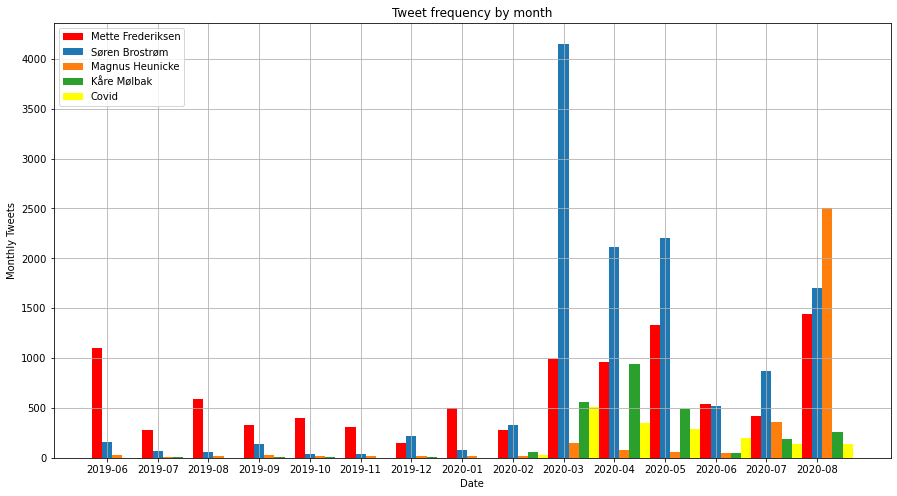

In [10]:
#Initiates figure
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

#Different x-axes were needed because Kåre only have data since 
x = np.arange(15)
y = np.append([1], [np.arange(3,15)])
z = np.arange(8,15)

width = 0.2


#Plotting the data from 2013M01 to 2020M02 and assigning them labels
ax.bar(x, twitter_lists.loc[twitter_lists['key'] == 'mette'].groupby('year_month')['text'].count(), width, color = 'red', label = 'Mette Frederiksen')
ax.bar(x+width, twitter_lists.loc[twitter_lists['key'] == 'søren'].groupby('year_month')['text'].count(), width, label = 'Søren Brostrøm')
ax.bar(x+width*2, twitter_lists.loc[twitter_lists['key'] == 'magnus'].groupby('year_month')['text'].count(), width, label = 'Magnus Heunicke')
ax.bar(y+width*3, twitter_lists.loc[twitter_lists['key'] == 'kåre'].groupby('year_month')['text'].count(), width, label = 'Kåre Mølbak')
ax.bar(z+width*4, twitter_lists.loc[twitter_lists['key'] == 'covid'].groupby('year_month')['text'].count(), width, color = 'yellow', label = 'Covid')

ax.set_xticks(x+width)
ax.set_xticklabels(twitter_lists.year_month.unique())
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Tweets')
ax.set_title('Tweet frequency by month')
ax.grid(True)
ax.legend(loc = 'upper left', frameon = True)

#Saves the figure as a png
plt.savefig('Tweet_frequency.png')

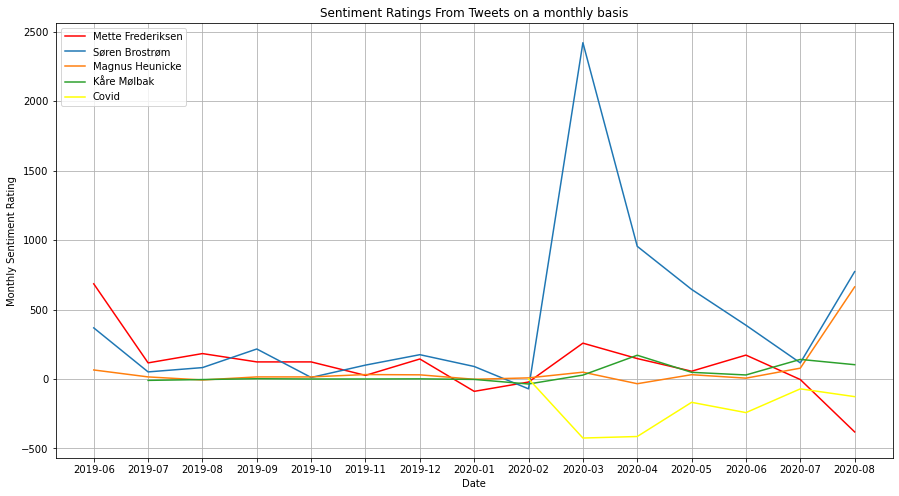

In [11]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1)

#Plotting the data from 2013M01 to 2020M02 and assigning them labels
ax.plot(twitter_lists.loc[twitter_lists['key'] == 'mette'].groupby('year_month')['afinn'].sum(), color = 'red', label = 'Mette Frederiksen')
ax.plot(twitter_lists.loc[twitter_lists['key'] == 'søren'].groupby('year_month')['afinn'].sum(), label = 'Søren Brostrøm')
ax.plot(twitter_lists.loc[twitter_lists['key'] == 'magnus'].groupby('year_month')['afinn'].sum(), label = 'Magnus Heunicke')
ax.plot(twitter_lists.loc[twitter_lists['key'] == 'kåre'].groupby('year_month')['afinn'].sum(), label = 'Kåre Mølbak')
ax.plot(twitter_lists.loc[twitter_lists['key'] == 'covid'].groupby('year_month')['afinn'].sum(), color = 'yellow', label = 'Covid')


ax.set_xlabel('Date')
ax.set_ylabel('Monthly Sentiment Rating')
ax.set_title('Sentiment Ratings From Tweets on a monthly basis')
ax.grid(True)
ax.legend(loc = 'upper left', frameon = True)

#Saves the figure as a png
plt.savefig('sentiment_all.png')

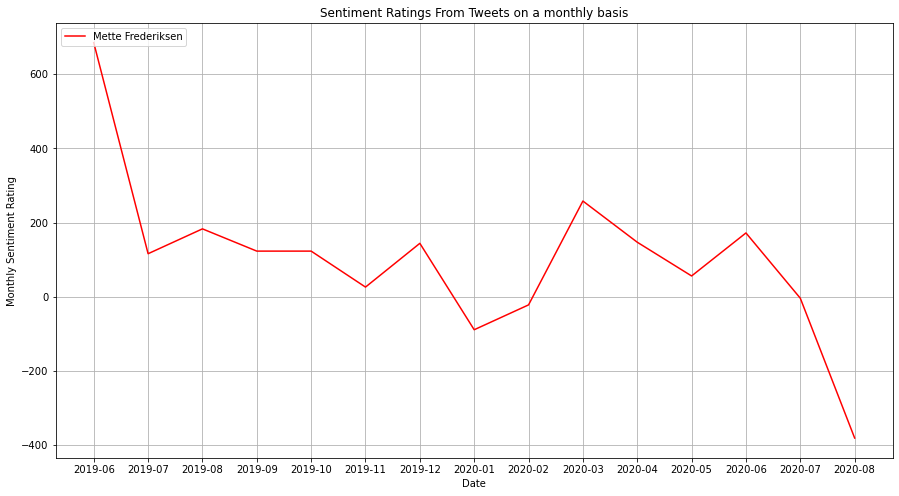

In [12]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1)

#Plotting the data from 2013M01 to 2020M02 and assigning them labels
ax.plot(twitter_lists.loc[twitter_lists['key'] == 'mette'].groupby('year_month')['afinn'].sum(), color = 'red', label = 'Mette Frederiksen')

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Sentiment Rating')
ax.set_title('Sentiment Ratings From Tweets on a monthly basis')
ax.grid(True)
ax.legend(loc = 'upper left', frameon = True)

#Saves the figure as a png
plt.savefig('sentiment_Mette.png')